In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
locals().update(np.load("result_parametric_negative_binomial.npz"))

# 1. Parameters

In [5]:
num_sim = Ys_sim.shape[0]
T = Ys_sim.shape[1]

In [6]:
T0 = 20
alpha = 1
K = 6.5

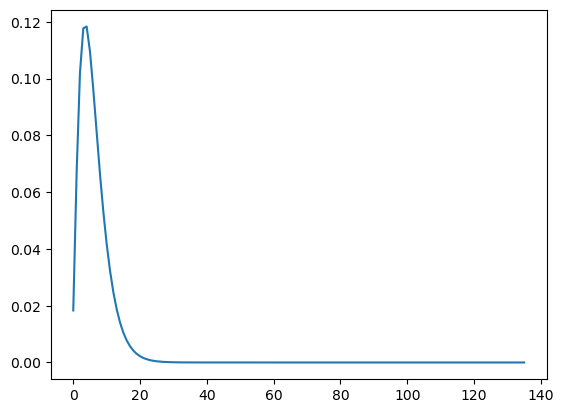

In [7]:
# g
plt.plot(g)

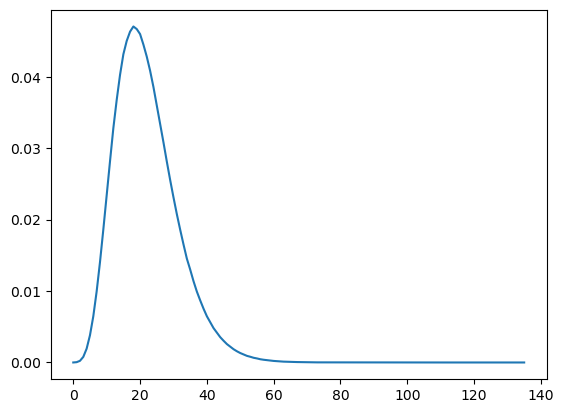

In [8]:
# pi
plt.plot(pi)

In [9]:
# A
d = A.shape[1]

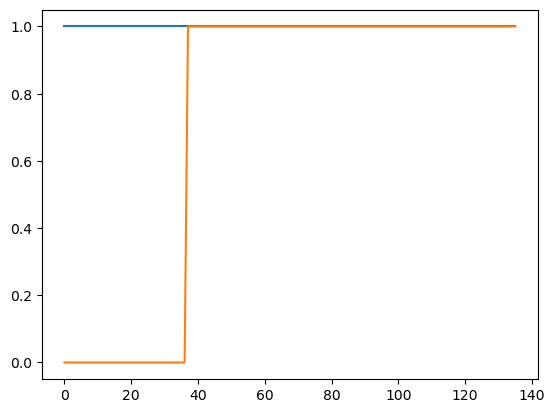

In [10]:
plt.plot(A)

# 3. Wald's Confidence Region coverage test

In [12]:
def NBLL(y, m, r):
    y = int(y)
    return (np.sum(np.log(1+(r-1)/(np.arange(y)+1))) 
            + r * np.log(r/(r+m)) 
            + y * np.log(m/(r+m)))

In [13]:
def dNBLLdr(y, m, r):
    y = int(y)
    return (np.sum(1/(np.arange(y)+r)) + np.log(r/(r+m)) + (m-y)/(r+m))

In [14]:
def d2NBLLdr2(y, m, r):
    y = int(y)
    return (-np.sum(1/(np.arange(y)+r)**2) + 1/r + 1/(r+m) - (m-y)/(r+m)**2)

In [18]:
Ihs_dth = np.zeros([num_sim, 2+d, 2+d])
Ts_dth = np.zeros(num_sim)
ps_dth = np.zeros(num_sim)

In [28]:
for iter_sim in np.arange(num_sim):
    start_sim = time.time()
    
    rhat = rsim[iter_sim,-1]
    mhat_0 = msim_0[iter_sim,-1]
    bhat = bsim[iter_sim,-1,:]
    Y_data = Ys_sim[iter_sim]
    
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = - K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])
        
    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
            np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    d2G = d2Rh[...,None] * np.concatenate([[0],g])[
            np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
    d2EY = mhat_0 * (Pi_inv_ImG @ (
        d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
        + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
        + d2G @ inv_ImG[:,:1]))[...,0]

    dldEY = Y_data/EY - (rhat+Y_data)/(rhat+EY)
    d2ldEY2 = - Y_data/EY**2 + (rhat+Y_data)/(rhat+EY)**2
    d2ldrdEY = - 1/(rhat+EY) + (rhat+Y_data)/(rhat+EY)**2

    d2ldr2 = np.sum([d2NBLLdr2(y, m, rhat) for y, m in zip(Y_data, EY)])
    d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
    d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
           + np.sum(dldEY * d2EY, 2)

    d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
    d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
    d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
            + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)

    d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                        [d2ldrdm, d2ldm2]])
    d2ldrmdb = np.stack([d2ldrdb, 
                         d2ldmdb])

    Ihs_dth[iter_sim] = - np.block([[d2ldrm2, d2ldrmdb],
                                    [d2ldrmdb.T, d2ldb2]])
    Ts_dth[iter_sim] = (bhat[1]-bmle[1])/np.sqrt(la.inv(Ihs_dth[iter_sim])[-1,-1])
    ps_dth[iter_sim] = 2*(1-stats.norm.cdf(np.abs(Ts_dth[iter_sim])))
    
    sys.__stdout__.write("%d-th simulation finished, %f sec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()

1-th simulation finished, 0.019829 sec.
2-th simulation finished, 0.015965 sec.
3-th simulation finished, 0.005828 sec.
4-th simulation finished, 0.008211 sec.
5-th simulation finished, 0.006102 sec.
6-th simulation finished, 0.008017 sec.
7-th simulation finished, 0.005941 sec.
8-th simulation finished, 0.008253 sec.
9-th simulation finished, 0.006537 sec.
10-th simulation finished, 0.014267 sec.
11-th simulation finished, 0.006212 sec.
12-th simulation finished, 0.007261 sec.
13-th simulation finished, 0.005843 sec.
14-th simulation finished, 0.004577 sec.
15-th simulation finished, 0.003563 sec.
16-th simulation finished, 0.006137 sec.
17-th simulation finished, 0.004667 sec.
18-th simulation finished, 0.006955 sec.
19-th simulation finished, 0.007739 sec.
20-th simulation finished, 0.008785 sec.
21-th simulation finished, 0.007070 sec.
22-th simulation finished, 0.007069 sec.
23-th simulation finished, 0.010705 sec.
24-th simulation finished, 0.008729 sec.
25-th simulation finished

212-th simulation finished, 0.017409 sec.
213-th simulation finished, 0.017956 sec.
214-th simulation finished, 0.014008 sec.
215-th simulation finished, 0.014427 sec.
216-th simulation finished, 0.007872 sec.
217-th simulation finished, 0.009807 sec.
218-th simulation finished, 0.014297 sec.
219-th simulation finished, 0.007129 sec.
220-th simulation finished, 0.008881 sec.
221-th simulation finished, 0.005375 sec.
222-th simulation finished, 0.006600 sec.
223-th simulation finished, 0.011780 sec.
224-th simulation finished, 0.005153 sec.
225-th simulation finished, 0.007490 sec.
226-th simulation finished, 0.005566 sec.
227-th simulation finished, 0.011443 sec.
228-th simulation finished, 0.005566 sec.
229-th simulation finished, 0.009643 sec.
230-th simulation finished, 0.006013 sec.
231-th simulation finished, 0.010899 sec.
232-th simulation finished, 0.006106 sec.
233-th simulation finished, 0.011152 sec.
234-th simulation finished, 0.005682 sec.
235-th simulation finished, 0.0086

424-th simulation finished, 0.011652 sec.
425-th simulation finished, 0.020010 sec.
426-th simulation finished, 0.009645 sec.
427-th simulation finished, 0.012771 sec.
428-th simulation finished, 0.012920 sec.
429-th simulation finished, 0.006014 sec.
430-th simulation finished, 0.010086 sec.
431-th simulation finished, 0.006241 sec.
432-th simulation finished, 0.008708 sec.
433-th simulation finished, 0.006484 sec.
434-th simulation finished, 0.006975 sec.
435-th simulation finished, 0.017070 sec.
436-th simulation finished, 0.006067 sec.
437-th simulation finished, 0.011587 sec.
438-th simulation finished, 0.006133 sec.
439-th simulation finished, 0.009889 sec.
440-th simulation finished, 0.018069 sec.
441-th simulation finished, 0.015707 sec.
442-th simulation finished, 0.007014 sec.
443-th simulation finished, 0.005901 sec.
444-th simulation finished, 0.021442 sec.
445-th simulation finished, 0.008241 sec.
446-th simulation finished, 0.005392 sec.
447-th simulation finished, 0.0058

621-th simulation finished, 0.016221 sec.
622-th simulation finished, 0.010430 sec.
623-th simulation finished, 0.010194 sec.
624-th simulation finished, 0.011066 sec.
625-th simulation finished, 0.017457 sec.
626-th simulation finished, 0.007249 sec.
627-th simulation finished, 0.008204 sec.
628-th simulation finished, 0.006003 sec.
629-th simulation finished, 0.011467 sec.
630-th simulation finished, 0.020689 sec.
631-th simulation finished, 0.006999 sec.
632-th simulation finished, 0.006221 sec.
633-th simulation finished, 0.009497 sec.
634-th simulation finished, 0.007140 sec.
635-th simulation finished, 0.005440 sec.
636-th simulation finished, 0.006549 sec.
637-th simulation finished, 0.004808 sec.
638-th simulation finished, 0.005980 sec.
639-th simulation finished, 0.007177 sec.
640-th simulation finished, 0.006552 sec.
641-th simulation finished, 0.009798 sec.
642-th simulation finished, 0.007343 sec.
643-th simulation finished, 0.005938 sec.
644-th simulation finished, 0.0047

840-th simulation finished, 0.010729 sec.
841-th simulation finished, 0.017066 sec.
842-th simulation finished, 0.007757 sec.
843-th simulation finished, 0.006588 sec.
844-th simulation finished, 0.011241 sec.
845-th simulation finished, 0.008001 sec.
846-th simulation finished, 0.007554 sec.
847-th simulation finished, 0.004202 sec.
848-th simulation finished, 0.012747 sec.
849-th simulation finished, 0.007380 sec.
850-th simulation finished, 0.007842 sec.
851-th simulation finished, 0.005687 sec.
852-th simulation finished, 0.003178 sec.
853-th simulation finished, 0.003519 sec.
854-th simulation finished, 0.003002 sec.
855-th simulation finished, 0.010348 sec.
856-th simulation finished, 0.006443 sec.
857-th simulation finished, 0.011387 sec.
858-th simulation finished, 0.009282 sec.
859-th simulation finished, 0.011209 sec.
860-th simulation finished, 0.013518 sec.
861-th simulation finished, 0.017789 sec.
862-th simulation finished, 0.017996 sec.
863-th simulation finished, 0.0278

(array([  1.,   9.,  34.,  77., 172., 225., 245., 156.,  66.,  15.]),
 array([-3.88007261, -3.21216147, -2.54425034, -1.87633921, -1.20842808,
        -0.54051695,  0.12739418,  0.79530531,  1.46321644,  2.13112757,
         2.7990387 ]),
 <BarContainer object of 10 artists>)

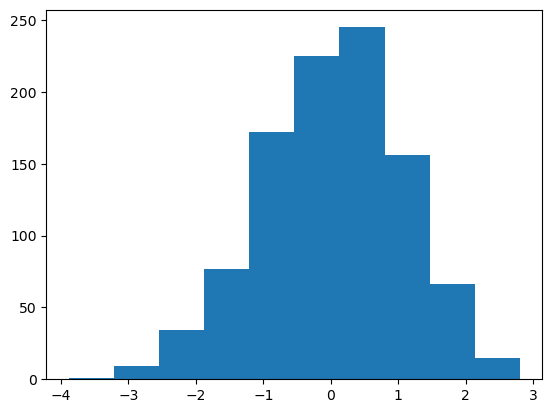

In [29]:
plt.hist(Ts_dth)

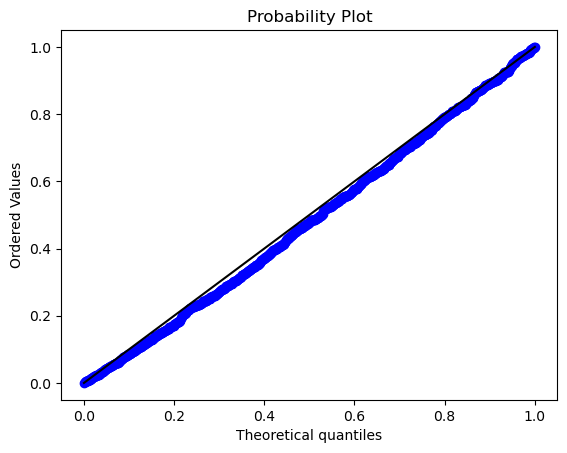

In [43]:
stats.probplot(ps_dth, dist = 'uniform', plot=plt, fit=False)
plt.plot([0, 1], [0, 1], color='black')
plt.show()

In [31]:
np.mean(np.abs(Ts_dth) < stats.norm.ppf(0.975))

0.939

# 6. Sandwich estimator coverage test

In [33]:
L_HAC = np.floor(4* (T/100)**(2/9))

In [34]:
w_HAC = np.maximum(1 - np.abs(np.arange(T)[:,None] - np.arange(T))/L_HAC, 0)

In [35]:
Ihs_sdw = np.zeros([num_sim, 2+d, 2+d])
Ts_sdw = np.zeros(num_sim)
ps_sdw = np.zeros(num_sim)

In [37]:
for iter_sim in np.arange(num_sim):
    start_sim = time.time()
    
    rhat = rsim[iter_sim,-1]
    mhat_0 = msim_0[iter_sim,-1]
    bhat = bsim[iter_sim,-1,:]
    Y_data = Ys_sim[iter_sim]
    
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = - K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])
        
    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
            np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    d2G = d2Rh[...,None] * np.concatenate([[0],g])[
            np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
    d2EY = mhat_0 * (Pi_inv_ImG @ (
        d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
        + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
        + d2G @ inv_ImG[:,:1]))[...,0]
    
    dltdr = np.array([dNBLLdr(y, m, rmle) for y, m in zip(Y_data, EY)])
    dltdm = dldEY * Pi_inv_ImG[:,0]
    dltdb = dldEY * d1EY
    
    dltdth = np.concatenate([np.array([dltdr, dltdm]), dltdb], 0)
    VEdl = dltdth @ w_HAC @ dltdth.T

    Ihs_sdw[iter_sim] = Ihs_dth[iter_sim] @ la.inv(VEdl) @ Ihs_dth[iter_sim]
    Ts_sdw[iter_sim] = (bhat[1]-bmle[1])/np.sqrt(la.inv(Ihs_sdw[iter_sim])[-1,-1])
    ps_sdw[iter_sim] = 2*(1-stats.norm.cdf(np.abs(Ts_sdw[iter_sim])))
    
    sys.__stdout__.write("%d-th simulation finished, %f sec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()

1-th simulation finished, 0.016598 sec.
2-th simulation finished, 0.010800 sec.
3-th simulation finished, 0.008244 sec.
4-th simulation finished, 0.006852 sec.
5-th simulation finished, 0.005799 sec.
6-th simulation finished, 0.005040 sec.
7-th simulation finished, 0.009134 sec.
8-th simulation finished, 0.008809 sec.
9-th simulation finished, 0.005037 sec.
10-th simulation finished, 0.006019 sec.
11-th simulation finished, 0.009105 sec.
12-th simulation finished, 0.014153 sec.
13-th simulation finished, 0.004419 sec.
14-th simulation finished, 0.009635 sec.
15-th simulation finished, 0.007581 sec.
16-th simulation finished, 0.006963 sec.
17-th simulation finished, 0.009285 sec.
18-th simulation finished, 0.006830 sec.
19-th simulation finished, 0.007935 sec.
20-th simulation finished, 0.008653 sec.
21-th simulation finished, 0.005679 sec.
22-th simulation finished, 0.008253 sec.
23-th simulation finished, 0.011242 sec.
24-th simulation finished, 0.006548 sec.
25-th simulation finished

209-th simulation finished, 0.011110 sec.
210-th simulation finished, 0.009742 sec.
211-th simulation finished, 0.008069 sec.
212-th simulation finished, 0.007385 sec.
213-th simulation finished, 0.021495 sec.
214-th simulation finished, 0.009314 sec.
215-th simulation finished, 0.019683 sec.
216-th simulation finished, 0.022241 sec.
217-th simulation finished, 0.005747 sec.
218-th simulation finished, 0.008578 sec.
219-th simulation finished, 0.006400 sec.
220-th simulation finished, 0.007957 sec.
221-th simulation finished, 0.007662 sec.
222-th simulation finished, 0.006311 sec.
223-th simulation finished, 0.008416 sec.
224-th simulation finished, 0.009094 sec.
225-th simulation finished, 0.013633 sec.
226-th simulation finished, 0.005942 sec.
227-th simulation finished, 0.005920 sec.
228-th simulation finished, 0.008066 sec.
229-th simulation finished, 0.016526 sec.
230-th simulation finished, 0.006756 sec.
231-th simulation finished, 0.009210 sec.
232-th simulation finished, 0.0106

410-th simulation finished, 0.011511 sec.
411-th simulation finished, 0.014058 sec.
412-th simulation finished, 0.007039 sec.
413-th simulation finished, 0.011561 sec.
414-th simulation finished, 0.007963 sec.
415-th simulation finished, 0.009167 sec.
416-th simulation finished, 0.006324 sec.
417-th simulation finished, 0.006554 sec.
418-th simulation finished, 0.006261 sec.
419-th simulation finished, 0.014870 sec.
420-th simulation finished, 0.008246 sec.
421-th simulation finished, 0.007258 sec.
422-th simulation finished, 0.008852 sec.
423-th simulation finished, 0.006028 sec.
424-th simulation finished, 0.007512 sec.
425-th simulation finished, 0.006916 sec.
426-th simulation finished, 0.006662 sec.
427-th simulation finished, 0.007252 sec.
428-th simulation finished, 0.005930 sec.
429-th simulation finished, 0.007635 sec.
430-th simulation finished, 0.008167 sec.
431-th simulation finished, 0.006707 sec.
432-th simulation finished, 0.005816 sec.
433-th simulation finished, 0.0068

626-th simulation finished, 0.008633 sec.
627-th simulation finished, 0.010721 sec.
628-th simulation finished, 0.012110 sec.
629-th simulation finished, 0.009283 sec.
630-th simulation finished, 0.004832 sec.
631-th simulation finished, 0.008506 sec.
632-th simulation finished, 0.009217 sec.
633-th simulation finished, 0.010150 sec.
634-th simulation finished, 0.005800 sec.
635-th simulation finished, 0.003513 sec.
636-th simulation finished, 0.004285 sec.
637-th simulation finished, 0.004848 sec.
638-th simulation finished, 0.006336 sec.
639-th simulation finished, 0.006575 sec.
640-th simulation finished, 0.011408 sec.
641-th simulation finished, 0.004204 sec.
642-th simulation finished, 0.006750 sec.
643-th simulation finished, 0.004637 sec.
644-th simulation finished, 0.009057 sec.
645-th simulation finished, 0.009830 sec.
646-th simulation finished, 0.006313 sec.
647-th simulation finished, 0.009073 sec.
648-th simulation finished, 0.007456 sec.
649-th simulation finished, 0.0118

834-th simulation finished, 0.012056 sec.
835-th simulation finished, 0.004440 sec.
836-th simulation finished, 0.005103 sec.
837-th simulation finished, 0.003981 sec.
838-th simulation finished, 0.003019 sec.
839-th simulation finished, 0.003127 sec.
840-th simulation finished, 0.009791 sec.
841-th simulation finished, 0.008306 sec.
842-th simulation finished, 0.005974 sec.
843-th simulation finished, 0.023184 sec.
844-th simulation finished, 0.005281 sec.
845-th simulation finished, 0.009745 sec.
846-th simulation finished, 0.010089 sec.
847-th simulation finished, 0.006058 sec.
848-th simulation finished, 0.009626 sec.
849-th simulation finished, 0.007291 sec.
850-th simulation finished, 0.007042 sec.
851-th simulation finished, 0.008012 sec.
852-th simulation finished, 0.007828 sec.
853-th simulation finished, 0.012691 sec.
854-th simulation finished, 0.011030 sec.
855-th simulation finished, 0.016198 sec.
856-th simulation finished, 0.010658 sec.
857-th simulation finished, 0.0107

(array([  2.,  12.,  40.,  93., 194., 242., 213., 135.,  56.,  13.]),
 array([-4.54811738, -3.7313056 , -2.91449381, -2.09768202, -1.28087024,
        -0.46405845,  0.35275333,  1.16956512,  1.9863769 ,  2.80318869,
         3.62000047]),
 <BarContainer object of 10 artists>)

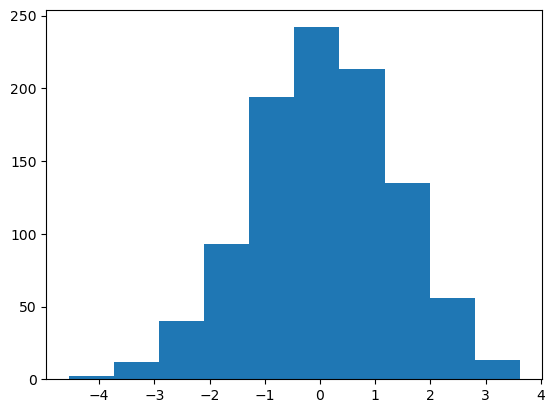

In [38]:
plt.hist(Ts_sdw)

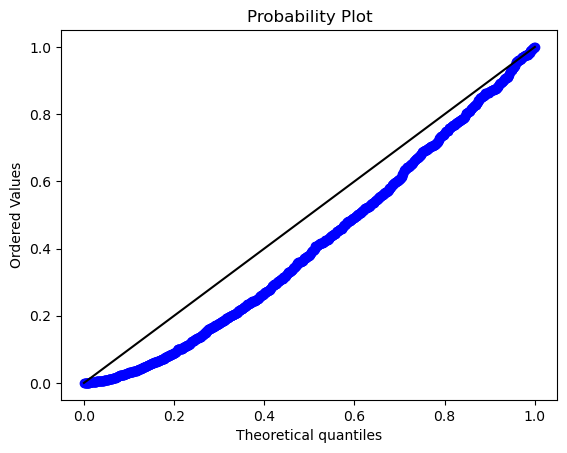

In [42]:
stats.probplot(ps_sdw, dist = 'uniform', plot=plt, fit=False)
plt.plot([0, 1], [0, 1], color='black')
plt.show()

In [40]:
np.mean(np.abs(Ts_sdw) < stats.norm.ppf(0.975))

0.862